In this notebook we are pereforming differnt Classification model.

1. K-NN where k is 5
2. K-NN where k is 20
3. Gini Index Decision Tree
4. Entropy Decision Tree
5. Gaussian Naive-Bayes

and comparing the them with the evaluation metric.

- Accuracy
- Precision
- Recall
- F1 Score

The Final result metrics tables is avaliable in `result_table.xlsx` in classfication sheet.

In [ ]:
import os 
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import sys 
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, make_scorer, precision_score, recall_score, f1_score
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean 

In [ ]:
################ UTILITY FUNCTIONS ###################
# display test scores
def t_test(results_array, model_names, score_name):
    string=""
    for i in range(len(model_names) - 1):
           for j in range(i, len(model_names)):
               if i == j:
                   continue
               t, p = stats.ttest_ind(results_array[i], results_array[j], equal_var=False)
               string += "\n"+score_name
               string += "T_Test between {} & {}: T Value = {}, P Value = {}".format(model_names[i], model_names[j], t, p)
               if p>0.05:
                   string += "p-value>0.05 so there's NO significant difference between models."
               else:
                   string += "p-value<=0.05 so there's A significant difference between models." 
    return string

In [ ]:
# plot ROC 
def plot_roc(fpr,tpr,model_name,selector_name):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + "/" + selector_name)
    plt.legend(loc="lower right")
    

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
################ NORMALIZATION ###################
df_original = pd.read_pickle('/content/gdrive/MyDrive/Project/Data/whole_set_selected_preprocessed_normalized_fixed.pkl')

X = df_original.loc[:, ["n_EAR", 
                    "n_MAR", "n_MOE", "n_EC",
                    "n_LEB", "n_SOP", "PERCLOS", "CLOSENESS"]]

y = df_original.loc[:, "DROWSINESS"]

# normalize each columns
scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)

In [ ]:
df_original


,subject,external_factors,facial_actions,frame_no,face_detected,left_ear,right_ear,avg_ear,MAR,MOE,left_ec,right_ec,avg_ec,left_leb,right_leb,avg_leb,left_sop,right_sop,avg_sop,reserved_for_calibration,PERCLOS,DROWSINESS,EAR,EC,LEB,SOP,n_left_ear,n_right_ear,n_avg_ear,n_left_ec,n_right_ec,n_avg_ec,n_left_leb,n_right_leb,n_avg_leb,n_left_sop,n_right_sop,n_avg_sop,n_EAR,n_EC,n_LEB,n_SOP,n_MAR,n_MOE,subject,n_021,CLOSENESS
0,026,noglasses,mix,3.0,1.0,0.281113,0.369565,0.325339,0.019936,0.061279,0.469984,0.543537,0.506761,32.010095,32.605777,32.307936,0.523548,0.464338,0.493943,True,0.0,0,0.325339,0.506761,32.307936,0.493943,0.564157,2.799494,2.117066,0.125826,1.504543,1.196686,0.321208,0.297037,0.362667,2.028623,0.267216,1.621183,2.117066,1.196686,0.362667,1.621183,-0.231568,-0.365698,026,-10.080994,0
1,026,noglasses,mix,4.0,1.0,0.290172,0.369565,0.329868,0.020341,0.061662,0.496282,0.534732,0.515507,32.605777,32.605777,32.605777,0.523548,0.479301,0.501424,True,0.0,0,0.329868,0.515507,32.605777,0.501424,0.618872,-0.517150,-0.025824,1.746788,-0.291571,0.667961,-0.825043,-1.278797,-1.270528,-0.325066,1.691583,0.585689,-0.025824,0.667961,-1.270528,0.585689,1.432530,1.437968,026,-10.080994,0
2,026,noglasses,mix,5.0,1.0,0.290172,0.353860,0.322016,0.040681,0.126332,0.544743,0.502060,0.523401,31.846369,32.348789,32.097579,0.501298,0.503625,0.502462,True,0.0,0,0.322016,0.523401,32.097579,0.502462,0.564157,1.606928,1.336608,1.721671,0.143878,0.983046,-0.746462,-1.278797,-1.229559,0.692123,1.691583,1.333265,1.336608,0.983046,-1.229559,1.333265,-0.231568,-0.317612,026,-10.080994,0
3,026,noglasses,mix,6.0,1.0,0.312348,0.395490,0.353919,0.030029,0.084846,0.505212,0.534889,0.520050,32.141548,33.754747,32.948147,0.529870,0.485899,0.507885,True,0.0,0,0.353919,0.520050,32.948147,0.507885,0.618872,0.623665,0.720766,0.102693,-0.782418,-0.536902,1.046612,-1.278797,-0.294733,-0.325066,0.267216,-0.108646,0.720766,-0.536902,-0.294733,-0.108646,0.492313,0.425032,026,-10.080994,0
4,026,noglasses,mix,7.0,1.0,0.296730,0.390935,0.343833,0.029361,0.085393,0.466081,0.583190,0.524635,31.513423,32.795714,32.154569,0.552866,0.464338,0.508602,True,0.0,0,0.343833,0.524635,32.154569,0.508602,0.618872,0.623665,0.720766,0.102693,-0.563624,-0.372174,-1.134845,-0.489410,-0.913282,-0.325066,0.267216,-0.108646,0.720766,-0.372174,-0.913282,-0.108646,-1.967199,-1.962194,026,-10.080994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515266,002,noglasses,nonsleepyCombination,2675.0,1.0,0.322438,0.366702,0.344570,0.046619,0.135296,0.519428,0.501465,0.510447,40.153337,44.334435,42.243886,0.500635,0.496381,0.498508,False,0.0,0,0.344570,0.510447,42.243886,0.498508,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1.000000,0
515267,002,noglasses,nonsleepyCombination,2676.0,1.0,0.305574,0.360779,0.333177,0.046619,0.139923,0.483056,0.487115,0.485085,39.996081,43.546340,41.771211,0.491398,0.473926,0.482662,False,0.0,0,0.333177,0.485085,41.771211,0.482662,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1.000000,0
515268,002,noglasses,nonsleepyCombination,2677.0,1.0,0.312124,0.393912,0.353018,0.057551,0.163025,0.461127,0.519349,0.490238,40.193898,43.382725,41.788312,0.518089,0.464807,0.491448,False,0.0,0,0.353018,0.490238,41.788312,0.491448,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1.000000,0
515269,002,noglasses,nonsleepyCombination,2678.0,1.0,0.321034,0.377428,0.349231,0.059428,0.170167,0.480536,0.521687,0.501112,39.862095,44.040659,41.

In [ ]:
################ MODEL and SCORE DEFINITIONS ###################
models = []
models.append(('KNN-5', KNeighborsClassifier(n_neighbors=5, n_jobs=-1)))
models.append(('CART-gini', DecisionTreeClassifier(criterion="gini"))) 
models.append(('NB', GaussianNB()))
models.append(('KNN-25', KNeighborsClassifier(n_neighbors=25, n_jobs=-1)))
models.append(('CART-entropy', DecisionTreeClassifier(criterion="entropy"))) 

scoring = []
scoring.append(('accuracy', accuracy_score))
scoring.append(('prec', precision_score))
scoring.append(('recall', recall_score))
scoring.append(('f1', f1_score))
scoring.append(('auc', roc_auc_score))

In [ ]:
################ VARIABLES ###################
fold_info_list = []
table1_output = ""
fold_no = 0

################ OUTER CV FOR T-TEST (5 FOLD) ###################
outer_cv = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
for train_index, test_index in outer_cv.split(X_scaled, y): 
    X_train, X_test, y_train, y_test = X_scaled[train_index], X_scaled[test_index], y[train_index], y[test_index]
    
    ############# FEATURE SELECTION (4 METHODS: FULL, ANOVA, MI, RFE-RF) #############
    table1_output += "OUTER CV FOLD NO: {}\n".format(fold_no)
    X_train_FULL = X_train
    
    ANOVA_selector = SelectKBest(f_classif, k=5)
    X_train_ANOVA = ANOVA_selector.fit_transform(X_train, y_train)
    print("\nANOVA scores: {}, ANOVA p-values: {}\n".format(ANOVA_selector.scores_, ANOVA_selector.pvalues_))
    table1_output += "\nANOVA scores: {}, ANOVA p-values: {}\n".format(ANOVA_selector.scores_, ANOVA_selector.pvalues_)
    
    MI_selector = SelectKBest(mutual_info_classif, k=5)
    X_train_MI = MI_selector.fit_transform(X_train, y_train)
    print("\nMI scores: {}, MI p-values: {}\n".format(MI_selector.scores_, MI_selector.pvalues_))
    table1_output += "\nMI scores: {}, MI p-values: {}\n".format(MI_selector.scores_, MI_selector.pvalues_)
    
    #estimator for recursive feature elimination
    # estimator = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', class_weight= None, max_features = None, random_state = 42,n_jobs=-1)
    estimator = DecisionTreeClassifier(random_state = 42)
    #inner cv for recursive feature elimination
    inner_cv = StratifiedShuffleSplit(n_splits=2,test_size=0.2, random_state = 42)
    RFE_selector = RFECV(estimator, step=1, cv=inner_cv, n_jobs=-1)
    X_train_RFE = RFE_selector.fit_transform(X_train, y_train)
    print("\nRFE rankings: {}, RFE grid-scores: {}\n".format(RFE_selector.ranking_, RFE_selector.grid_scores_))
    table1_output += "\nRFE rankings: {}, RFE grid-scores: {}\n".format(RFE_selector.ranking_, RFE_selector.grid_scores_)
    
    ############# TEST RESULTS FOR FEATURE SELECTION METHODS #############
    fold_info = {
        model_name:{
            'FULL': {
                score_name:0 for score_name,score in scoring
                },
            'ANOVA': {
                score_name:0 for score_name,score in scoring
                },
            'MI': {
                score_name:0 for score_name,score in scoring
                },
            'RFE': {
                score_name:0 for score_name,score in scoring
                }
            } for model_name, model in models
        }
    for model_name, model in models:
        # transform X_test according to feature selection methods
        X_test_FULL = X_test
        X_test_ANOVA = ANOVA_selector.transform(X_test)
        X_test_MI = MI_selector.transform(X_test)
        X_test_RFE = RFE_selector.transform(X_test)
        # make predictions
        model.fit(X_train_FULL,y_train)
        y_pred_FULL = model.predict(X_test_FULL)
        model.fit(X_train_ANOVA,y_train)
        y_pred_ANOVA = model.predict(X_test_ANOVA)
        model.fit(X_train_MI,y_train)
        y_pred_MI = model.predict(X_test_MI)
        model.fit(X_train_RFE,y_train)
        y_pred_RFE = model.predict(X_test_RFE)
        # save evaluation metrics
        for score_name, score in scoring:
            score_FULL = score(y_test,y_pred_FULL)
            score_ANOVA = score(y_test,y_pred_ANOVA)
            score_MI = score(y_test,y_pred_MI)
            score_RFE = score(y_test,y_pred_RFE)
            fold_info[model_name]['FULL'][score_name] = score_FULL,
            fold_info[model_name]['ANOVA'][score_name] = score_ANOVA,
            fold_info[model_name]['MI'][score_name] = score_MI,
            fold_info[model_name]['RFE'][score_name] = score_RFE,

        # save ROC metrics
        fpr_FULL, tpr_FULL, _ = roc_curve(y_test,y_pred_FULL)
        fold_info[model_name]['FULL']['ROC_fpr'] = fpr_FULL
        fold_info[model_name]['FULL']['ROC_tpr'] = tpr_FULL
        fpr_ANOVA, tpr_ANOVA, _ = roc_curve(y_test,y_pred_ANOVA)
        fold_info[model_name]['ANOVA']['ROC_fpr'] = fpr_ANOVA
        fold_info[model_name]['ANOVA']['ROC_tpr'] = tpr_ANOVA
        fpr_MI, tpr_MI, _ = roc_curve(y_test,y_pred_MI)
        fold_info[model_name]['MI']['ROC_fpr'] = fpr_MI
        fold_info[model_name]['MI']['ROC_tpr'] = tpr_MI
        fpr_RFE, tpr_RFE, _ = roc_curve(y_test,y_pred_RFE)
        fold_info[model_name]['RFE']['ROC_fpr'] = fpr_RFE
        fold_info[model_name]['RFE']['ROC_tpr'] = tpr_RFE
        
        # save confusion matrix
        conf_FULL = confusion_matrix(y_test,y_pred_FULL)
        fold_info[model_name]['FULL']['confusion_matrix'] = conf_FULL
        conf_ANOVA = confusion_matrix(y_test,y_pred_ANOVA)
        fold_info[model_name]['ANOVA']['confusion_matrix'] = conf_ANOVA
        conf_MI = confusion_matrix(y_test,y_pred_MI)
        fold_info[model_name]['MI']['confusion_matrix'] = conf_MI
        conf_RFE = confusion_matrix(y_test,y_pred_RFE)
        fold_info[model_name]['RFE']['confusion_matrix'] = conf_RFE
            
            
    fold_info_list.append(fold_info)
    fold_no += 1 


ANOVA scores: [1.67537120e+01 1.06532368e+03 1.12455010e+03 2.12712008e+01
 5.85441436e+02 6.01620365e+00 1.99827190e+04 7.84590803e-01], ANOVA p-values: [4.25670145e-005 2.26291606e-233 3.28237204e-246 3.98795898e-006
 3.02666886e-129 1.41755182e-002 0.00000000e+000 3.75741293e-001]


MI scores: [0.02475419 0.07600887 0.0155789  0.01680919 0.04188414 0.04847683
 0.07261062 0.01566866], MI p-values: None



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)



RFE rankings: [1 1 1 2 1 3 1 4], RFE grid-scores: [[0.56492892 0.56824026]
 [0.5923536  0.58970938]
 [0.59213527 0.58627675]
 [0.70153074 0.69997817]
 [0.71034884 0.70732861]
 [0.70490272 0.70501189]
 [0.70482995 0.70381107]
 [0.70871137 0.70828684]]


ANOVA scores: [2.24531198e+01 1.04946718e+03 1.11908253e+03 2.62016185e+01
 5.81233552e+02 8.87247588e+00 2.00568540e+04 2.75857553e-04], ANOVA p-values: [2.15407064e-006 6.19859710e-230 5.02675338e-245 3.07702350e-007
 2.48291897e-128 2.89519090e-003 0.00000000e+000 9.86748584e-001]


MI scores: [0.02385659 0.07753162 0.0173452  0.01679548 0.0424823  0.0475265
 0.07207514 0.01499631], MI p-values: None



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)



RFE rankings: [1 1 1 2 1 3 1 4], RFE grid-scores: [[0.5687497  0.56746398]
 [0.58872689 0.5888118 ]
 [0.5906676  0.58886032]
 [0.70125176 0.70179758]
 [0.70991218 0.71307797]
 [0.70613993 0.70919655]
 [0.70540003 0.70595798]
 [0.71105235 0.708396  ]]


ANOVA scores: [1.89652911e+01 9.41315781e+02 9.96554658e+02 2.09245885e+01
 5.20329495e+02 5.98330191e+00 2.02236683e+04 8.20379989e-03], ANOVA p-values: [1.33150158e-005 1.75392904e-206 1.84010512e-218 4.77861800e-006
 4.23039401e-115 1.44423548e-002 0.00000000e+000 9.27830476e-001]


MI scores: [0.02342978 0.07700892 0.01612238 0.01703604 0.04167168 0.04901815
 0.07186663 0.01671021], MI p-values: None



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)



RFE rankings: [1 1 1 2 1 3 1 4], RFE grid-scores: [[0.56745185 0.56751249]
 [0.5856824  0.58502741]
 [0.58941827 0.58591286]
 [0.70045122 0.69952938]
 [0.70992431 0.70968172]
 [0.70262239 0.70713454]
 [0.70584882 0.70643103]
 [0.70730435 0.71026394]]


ANOVA scores: [2.16095920e+01 1.06291959e+03 1.14015772e+03 2.44917819e+01
 6.15386892e+02 7.82935210e+00 2.00389373e+04 6.71179187e-02], ANOVA p-values: [3.34279681e-006 7.51369486e-233 1.35937917e-249 7.46568039e-007
 9.48567453e-136 5.14069071e-003 0.00000000e+000 7.95580387e-001]


MI scores: [0.02295541 0.07659878 0.01638113 0.01782826 0.04318033 0.04876023
 0.07301573 0.01579226], MI p-values: None



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)



RFE rankings: [1 1 1 2 1 3 1 4], RFE grid-scores: [[0.56861627 0.56834943]
 [0.58747756 0.58537917]
 [0.58893309 0.58666489]
 [0.70220998 0.69606036]
 [0.70990005 0.70845665]
 [0.70783805 0.7058003 ]
 [0.70838387 0.69995391]
 [0.71048227 0.70707389]]


ANOVA scores: [1.60012671e+01 1.06050313e+03 1.09673066e+03 1.80742263e+01
 5.65862315e+02 4.39143179e+00 2.01652836e+04 4.91875669e-01], ANOVA p-values: [6.33111382e-005 2.51029060e-232 3.51790703e-240 2.12504623e-005
 5.41923952e-125 3.61205763e-002 0.00000000e+000 4.83092198e-001]


MI scores: [0.02302899 0.07672361 0.01592139 0.01708025 0.04175442 0.04824134
 0.07240323 0.01573464], MI p-values: None



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)



RFE rankings: [1 1 1 2 1 3 1 4], RFE grid-scores: [[0.56683324 0.56964728]
 [0.58620397 0.58655572]
 [0.58991558 0.59249915]
 [0.70327738 0.70396875]
 [0.71043375 0.70957256]
 [0.70652807 0.70740139]
 [0.70656446 0.70630974]
 [0.71048227 0.70805638]]



In [ ]:
############# T-TEST #############

results = {
    "FULL": {score_name:[] for score_name,score in scoring},
    "ANOVA": {score_name:[] for score_name,score in scoring},
    "MI": {score_name:[] for score_name,score in scoring},
    "RFE": {score_name:[] for score_name,score in scoring},
    }

# build result arrays for corresponding metrics
for score_name, score in scoring:
    for model_name, model in models:
        model_results_FULL = []
        model_results_ANOVA = []
        model_results_MI = []
        model_results_RFE = []
        for fold_info in fold_info_list:
             model_results_FULL.append(fold_info[model_name]['FULL'][score_name])
             model_results_ANOVA.append(fold_info[model_name]['ANOVA'][score_name])
             model_results_MI.append(fold_info[model_name]['MI'][score_name])
             model_results_RFE.append(fold_info[model_name]['RFE'][score_name])
        results['FULL'][score_name].append(model_results_FULL)
        results['ANOVA'][score_name].append(model_results_ANOVA)
        results['MI'][score_name].append(model_results_MI)
        results['RFE'][score_name].append(model_results_RFE)

# calculate t-test on 5 folds for corresponding model and metric
t_test_output=""
model_names = [model_name for model_name, model in models]
for score_name, score in scoring:
        t_test_output += '\nFULL'
        results_array = results['FULL'][score_name]
        t_test_output += t_test(results_array, model_names, score_name)
        t_test_output += '\nANOVA'
        results_array = results['ANOVA'][score_name]
        t_test_output += t_test(results_array, model_names, score_name)
        t_test_output += '\nMI'
        results_array = results['MI'][score_name]
        t_test_output += t_test(results_array, model_names, score_name)
        t_test_output += '\nRFE'
        results_array = results['RFE'][score_name]
        t_test_output += t_test(results_array, model_names, score_name)
        print(t_test_output)



FULL
accuracyT_Test between KNN-5 & CART-gini: T Value = [-14.50714627], P Value = [5.16596361e-07]p-value<=0.05 so there's A significant difference between models.
accuracyT_Test between KNN-5 & NB: T Value = [154.8418234], P Value = [3.06274148e-12]p-value<=0.05 so there's A significant difference between models.
accuracyT_Test between KNN-5 & KNN-25: T Value = [-7.95181058], P Value = [5.63517057e-05]p-value<=0.05 so there's A significant difference between models.
accuracyT_Test between KNN-5 & CART-entropy: T Value = [-18.63474311], P Value = [9.9221174e-08]p-value<=0.05 so there's A significant difference between models.
accuracyT_Test between CART-gini & NB: T Value = [162.56910293], P Value = [9.97018576e-13]p-value<=0.05 so there's A significant difference between models.
accuracyT_Test between CART-gini & KNN-25: T Value = [8.11015678], P Value = [5.62550769e-05]p-value<=0.05 so there's A significant difference between models.
accuracyT_Test between CART-gini & CART-entropy:

In [ ]:
############ EVALUATION METRICS #####################

metrics_output = ""

for model_name, model in models:
    metrics_output += "\n{} with full features\n".format(model_name)
    for score_name, score in scoring:
        metrics_output += "\n{}: {},{},{},{},{}, average: {}".format(score_name, *[fold_info[model_name]["FULL"][score_name][0] for fold_info in fold_info_list], mean([fold_info[model_name]["FULL"][score_name][0] for fold_info in fold_info_list]))
    metrics_output += "\n\n{} with ANOVA\n".format(model_name)
    for score_name, score in scoring:
        metrics_output += "\n{}: {},{},{},{},{}, average: {}".format(score_name, *[fold_info[model_name]["ANOVA"][score_name][0] for fold_info in fold_info_list], mean([fold_info[model_name]["ANOVA"][score_name][0] for fold_info in fold_info_list]))
    metrics_output += "\n\n{} with MI\n".format(model_name)
    for score_name, score in scoring:
        metrics_output += "\n{}: {},{},{},{},{}, average: {}".format(score_name, *[fold_info[model_name]["MI"][score_name][0] for fold_info in fold_info_list], mean([fold_info[model_name]["MI"][score_name][0] for fold_info in fold_info_list]))
    metrics_output += "\n\n{} with RFE\n".format(model_name)
    for score_name, score in scoring:
        metrics_output += "\n{}: {},{},{},{},{}, average: {}".format(score_name, *[fold_info[model_name]["RFE"][score_name][0] for fold_info in fold_info_list], mean([fold_info[model_name]["RFE"][score_name][0] for fold_info in fold_info_list]))

print(metrics_output)



KNN-5 with full features

accuracy: 0.7087962738343603,0.7111708424709375,0.7103363285267917,0.7100161080598522,0.7103945504298718, average: 0.7101428206643627
prec: 0.737205926023691,0.7392265557975318,0.7393384544069929,0.7384140401855734,0.7392498469581906, average: 0.738686964674396
recall: 0.7603886601095872,0.7624606483451034,0.7599591593635667,0.7610822768654811,0.7603205935404825, average: 0.7608422676448442
f1: 0.7486178589378455,0.750663863223234,0.7495070026600877,0.7495768180066034,0.749637185735737, average: 0.7496005457127015
auc: 0.700364123908798,0.7027887246783204,0.7022266387709477,0.7016705385095091,0.7022339961922065, average: 0.7018568044119563

KNN-5 with ANOVA

accuracy: 0.6880985881325505,0.6911522114619519,0.6904050303724261,0.6902982902167796,0.6902109573621596, average: 0.6900330155091735
prec: 0.7182535128133659,0.7215906286504006,0.7220054881475849,0.721259868475269,0.7216176494872599, average: 0.720945429514776
recall: 0.745448048191131,0.7463456138858164

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


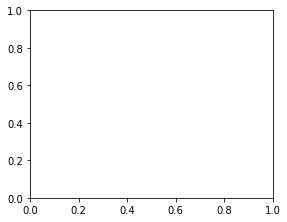

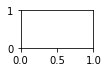

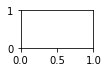

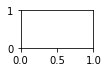

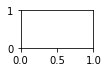

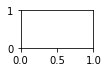

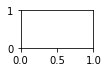

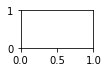

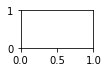

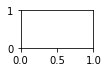

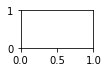

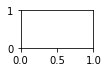

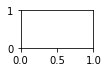

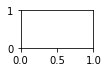

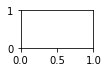

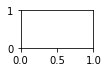

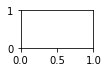

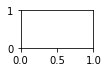

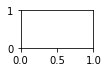

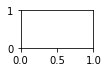

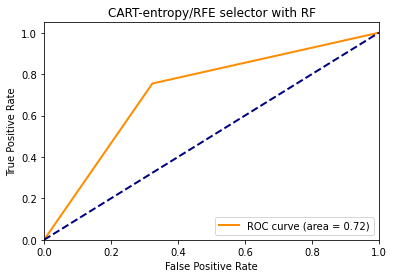

In [ ]:
############ ROC CURVES #########################
# plot curves in grid
plt.figure(figsize=(20,20))
for i in range(0, 5):
    plt.subplot(5, 4, 4*i+1)
    fpr = np.mean([fold_info[model_names[i]]['FULL']['ROC_fpr'] for fold_info in fold_info_list], axis=0)
    tpr = np.mean([fold_info[model_names[i]]['FULL']['ROC_tpr'] for fold_info in fold_info_list], axis=0)
    plot_roc(fpr,tpr,model_names[i],"FULL features")
    
    plt.subplot(5, 4, 4*i+2)
    fpr = np.mean([fold_info[model_names[i]]['ANOVA']['ROC_fpr'] for fold_info in fold_info_list], axis=0)
    tpr = np.mean([fold_info[model_names[i]]['ANOVA']['ROC_tpr'] for fold_info in fold_info_list], axis=0)
    plot_roc(fpr,tpr,model_names[i],"ANOVA selector")
    
    plt.subplot(5, 4, 4*i+3)
    fpr = np.mean([fold_info[model_names[i]]['MI']['ROC_fpr'] for fold_info in fold_info_list], axis=0)
    tpr = np.mean([fold_info[model_names[i]]['MI']['ROC_tpr'] for fold_info in fold_info_list], axis=0)
    plot_roc(fpr,tpr,model_names[i],"Mutual Info selector")
    
    plt.subplot(5, 4, 4*i+4)
    fpr = np.mean([fold_info[model_names[i]]['RFE']['ROC_fpr'] for fold_info in fold_info_list], axis=0)
    tpr = np.mean([fold_info[model_names[i]]['RFE']['ROC_tpr'] for fold_info in fold_info_list], axis=0)
    plot_roc(fpr,tpr,model_names[i],"RFE selector with RF")

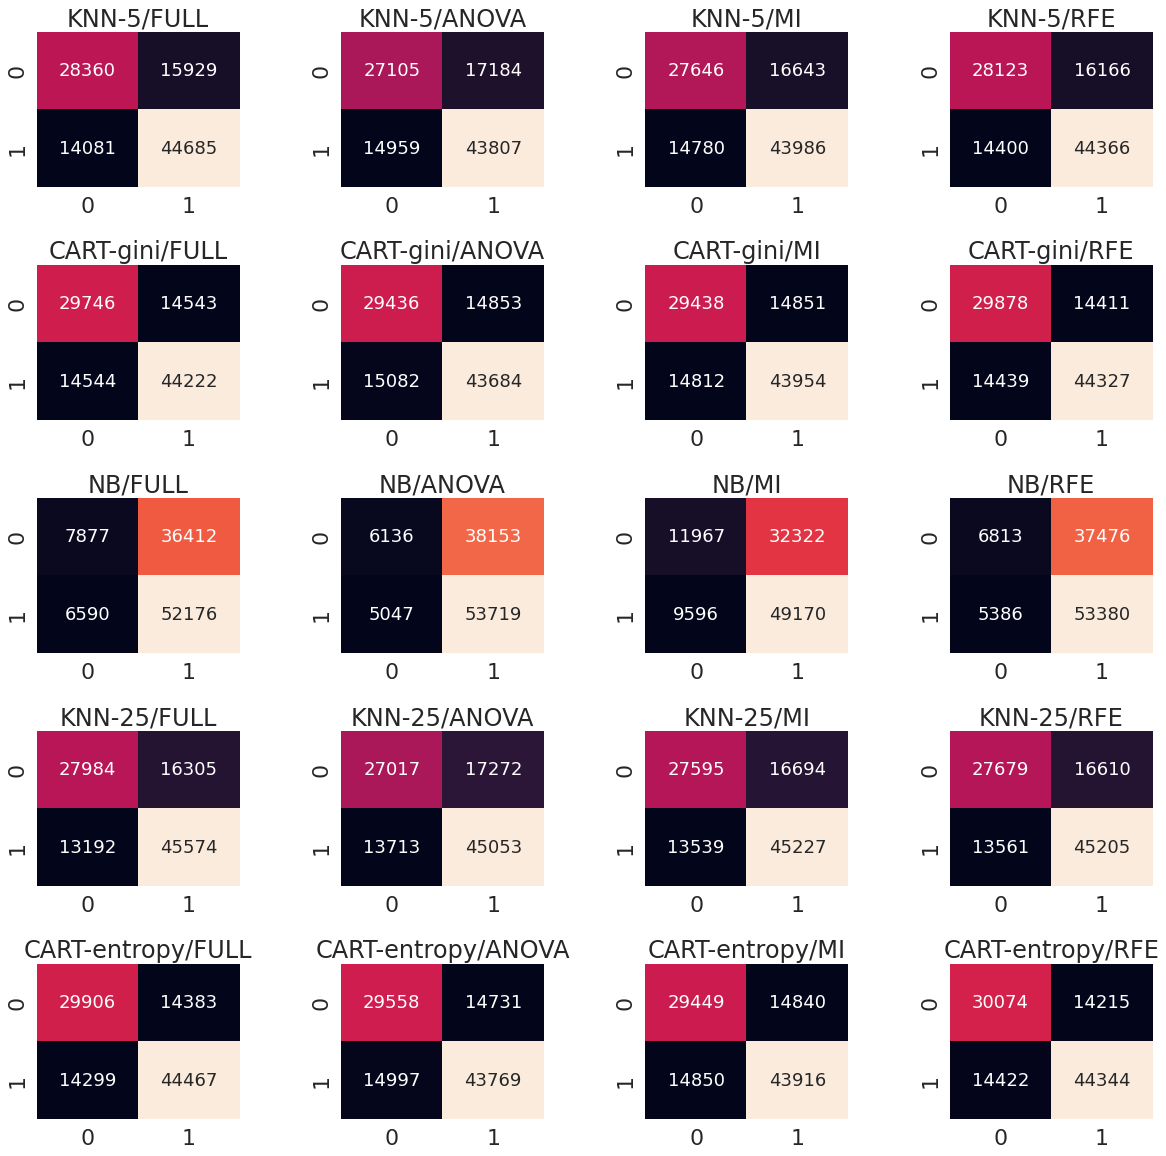

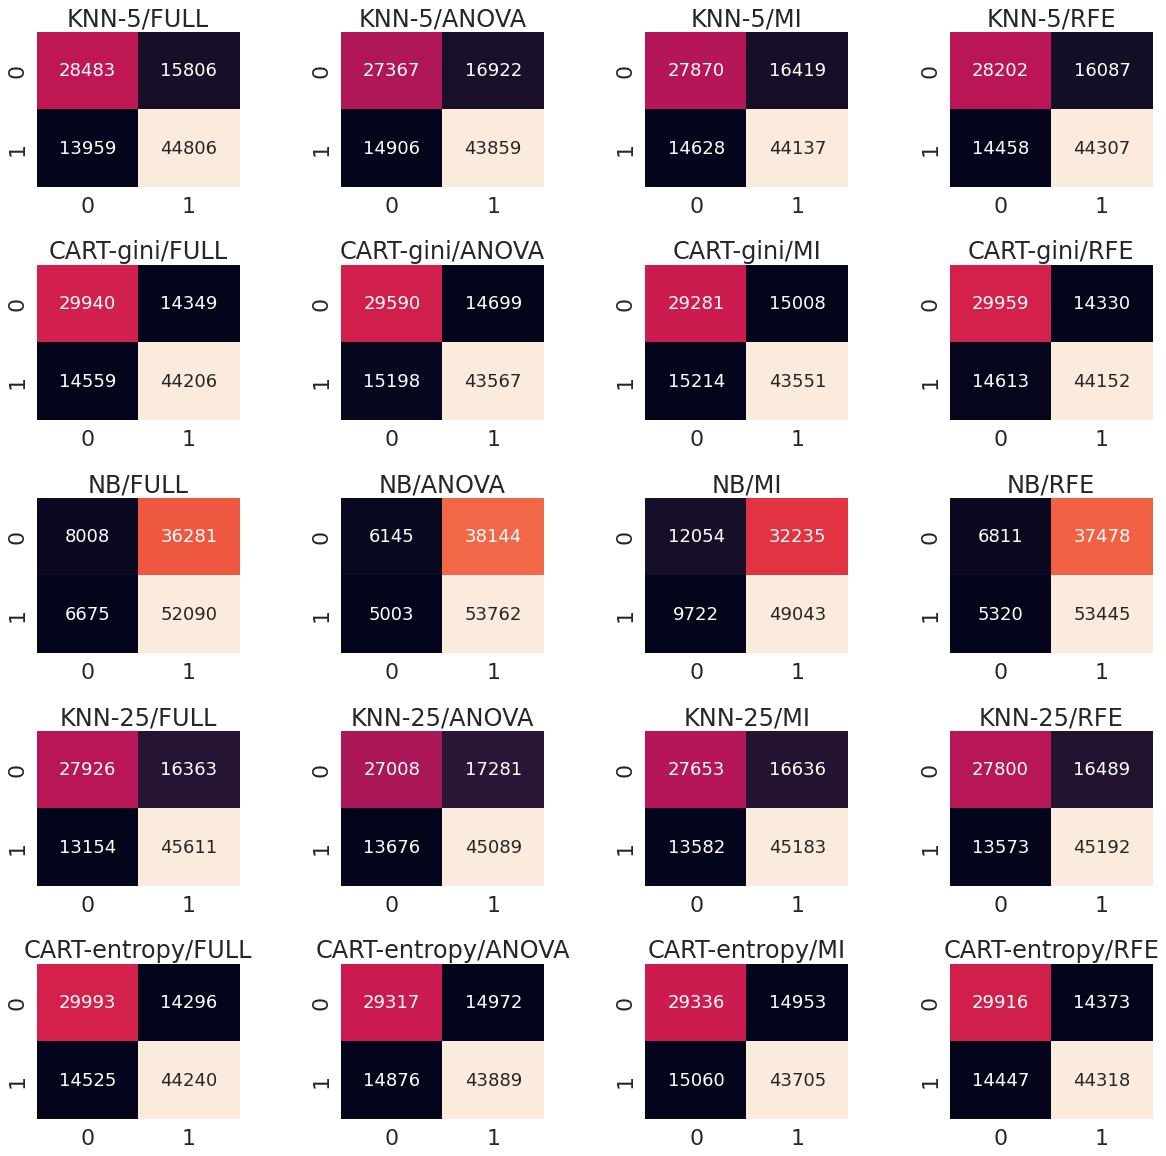

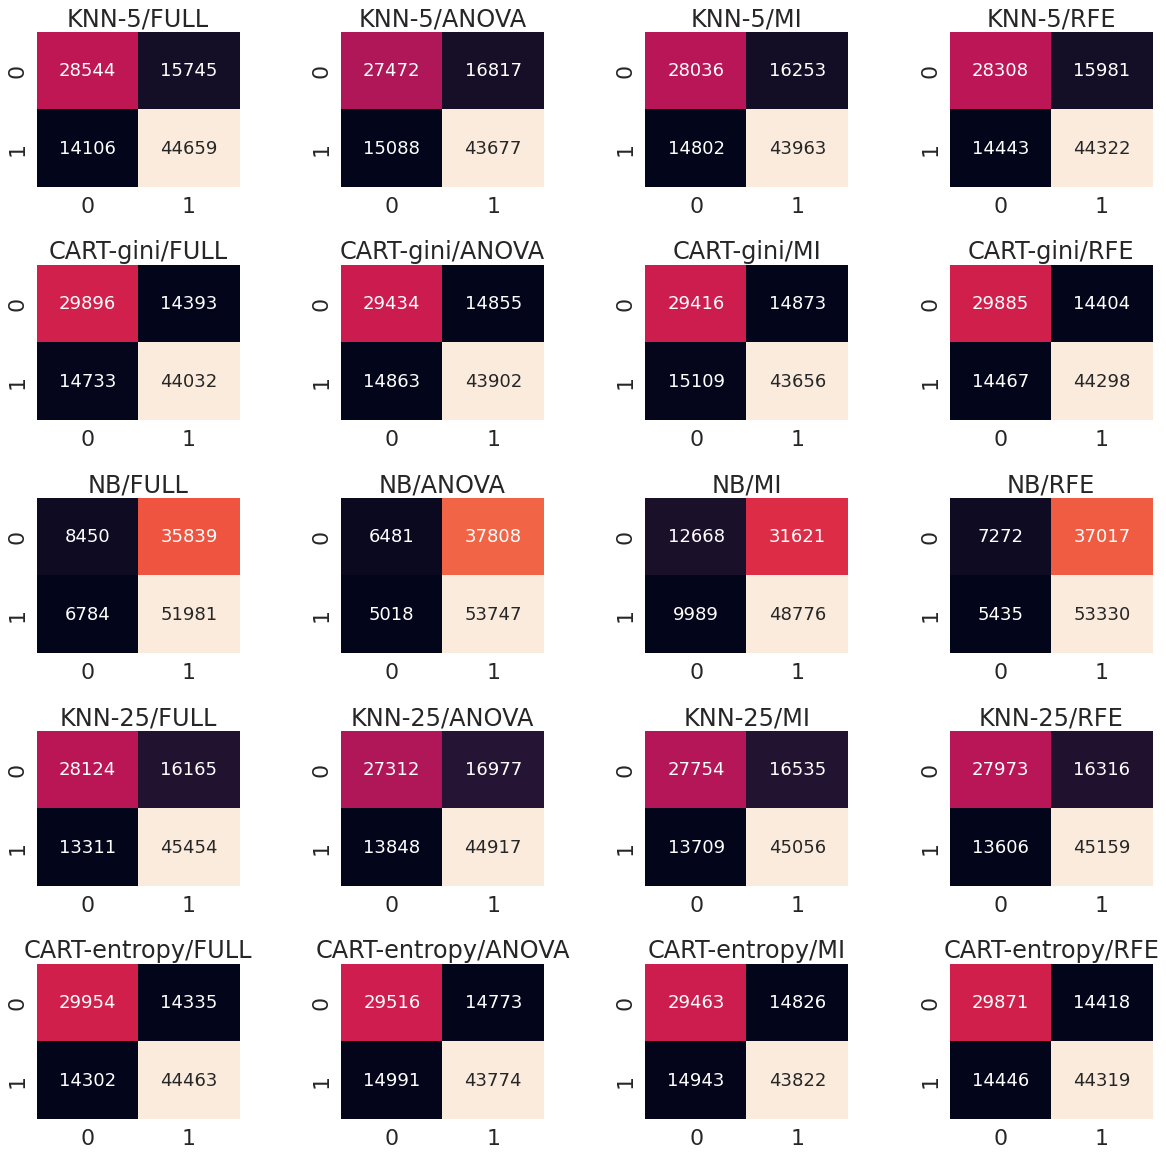

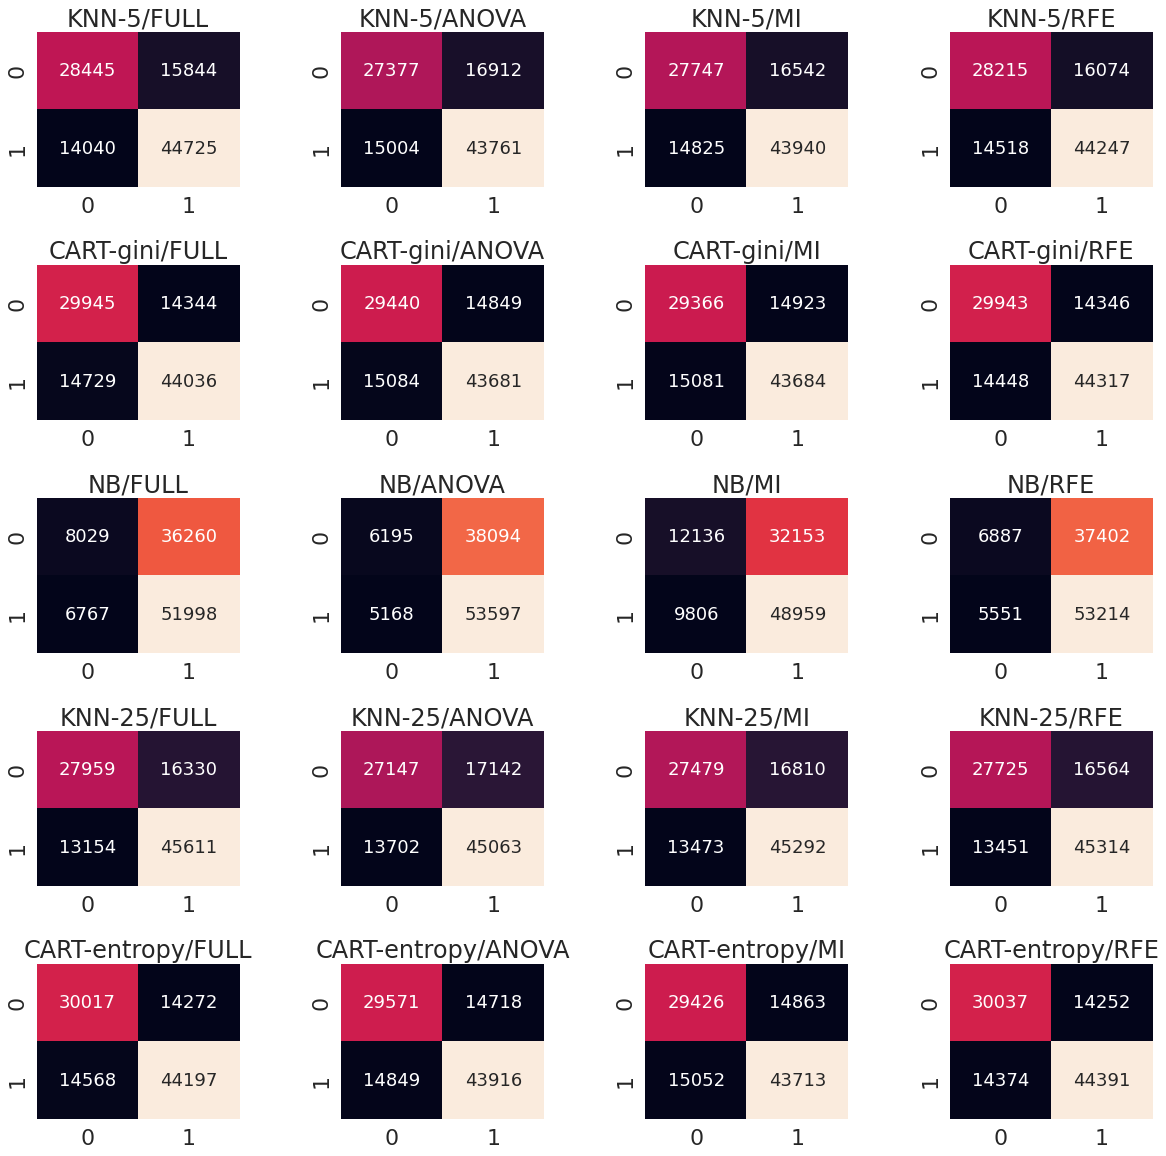

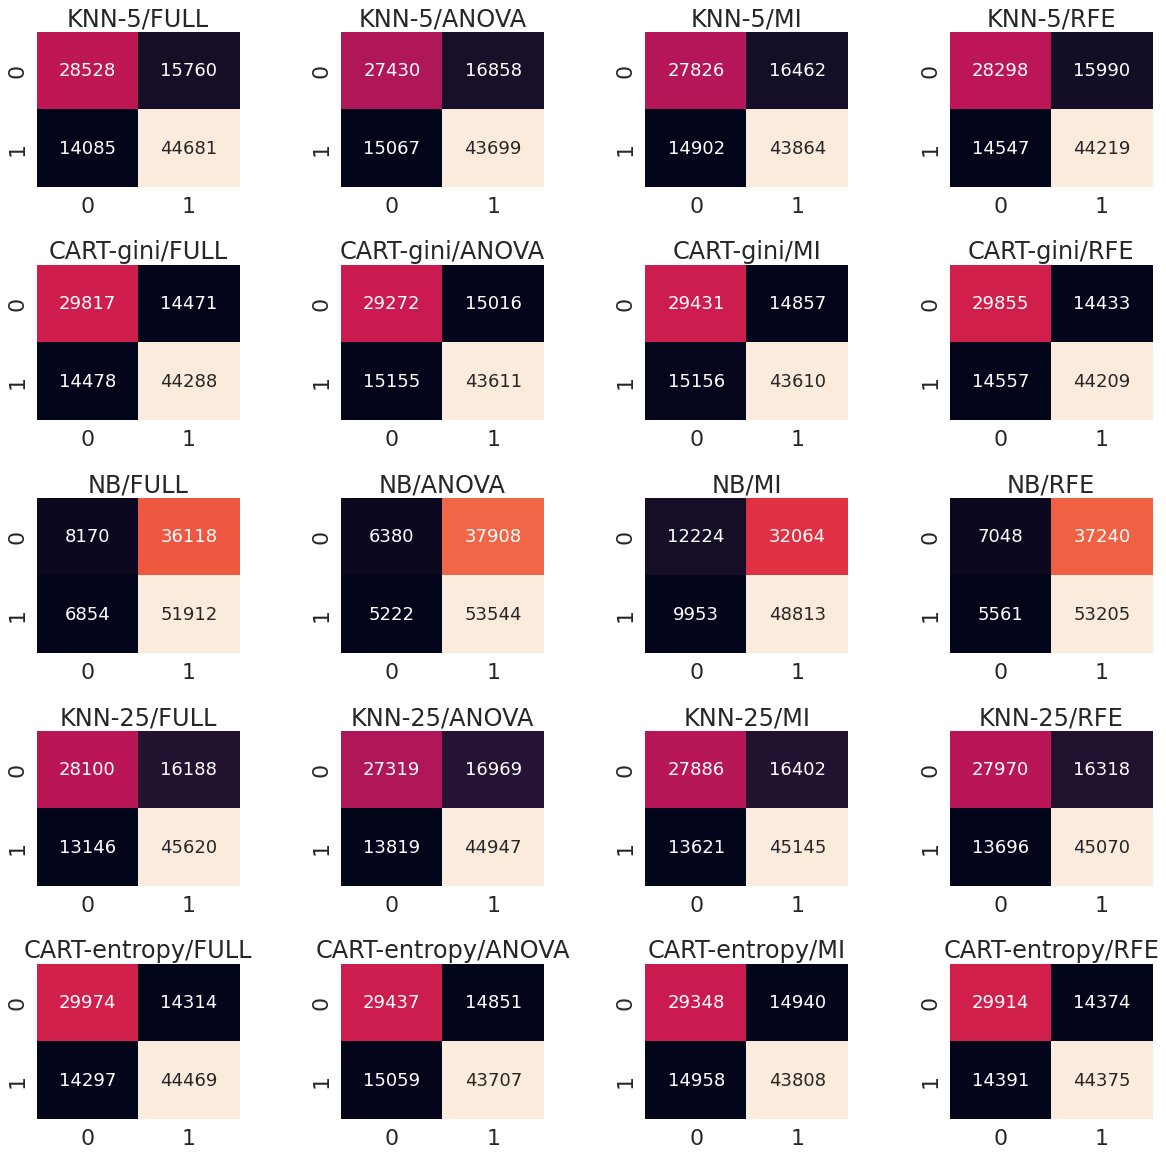

In [ ]:
############ CONFUSION MATRICES #########################    
sns.set(font_scale=2.0) # for label size


for no, fold_info in enumerate(fold_info_list,1):
    plt.figure(figsize=(20,20))
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

    # plt.title("FOLD NO: {}".format(no))
    for i in range(0, 5):
        plt.subplot(5, 4, 4*i+1)
        plt.title(model_names[i] + "/" + "FULL")
        df_cm = pd.DataFrame(fold_info[model_names[i]]['FULL']['confusion_matrix'])
        sns.heatmap(df_cm, annot=True, fmt="d",cbar=False, annot_kws={"size": 18}) # font size
        
        plt.subplot(5, 4, 4*i+2)
        plt.title(model_names[i] + "/" + "ANOVA")
        df_cm = pd.DataFrame(fold_info[model_names[i]]['ANOVA']['confusion_matrix'])
        sns.heatmap(df_cm, annot=True, fmt="d",cbar=False, annot_kws={"size": 18}) # font size
        
        plt.subplot(5, 4, 4*i+3)
        plt.title(model_names[i] + "/" + "MI")
        df_cm = pd.DataFrame(fold_info[model_names[i]]['MI']['confusion_matrix'])
        sns.heatmap(df_cm, annot=True, fmt="d",cbar=False, annot_kws={"size": 18}) # font size
        
        plt.subplot(5, 4, 4*i+4)
        plt.title(model_names[i] + "/" + "RFE")
        df_cm = pd.DataFrame(fold_info[model_names[i]]['RFE']['confusion_matrix'])
        sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, annot_kws={"size": 18}) # font size